In [21]:
# Import appropriate modules
import pandas as pd
import datetime
import numpy as np
import yfinance as yf
from pathlib import Path
from datetime import datetime
import hvplot
import hvplot.pandas
from fbprophet import Prophet
# import plot change point function
from fbprophet.plot import add_changepoints_to_plot

In [2]:
# Define function to retrieve ticker daily return data from yahoo using ticker, start date and end date
def retrieve_yahoo_data_return(ticker = 'spy', start_date = '2007-07-01', end_date = '2021-10-03'):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and calculate the daily return
        price_df = yahoo_data.history(start=start_date, end=end_date).Close.pct_change()
        price_df.name = ticker
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [3]:
# Define function to retrieve ticker daily close data from yahoo using ticker, start date and end date
def retrieve_yahoo_data_close(ticker = 'spy', start_date = '2007-07-01', end_date = '2021-10-03'):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and save the Close data
        price_df = yahoo_data.history(start=start_date, end=end_date).Close
        price_df.name = ticker
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [4]:
# Define function to retrieve ticker daily return data from yahoo using ticker, start date and end date
def retrieve_yahoo_data_volume(ticker = 'spy', start_date = '2007-07-01', end_date = '2021-10-03'):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and calculate the daily return
        price_df = yahoo_data.history(start=start_date, end=end_date).Volume
        price_df.name = ticker
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [25]:
# Define function to retrieve ticker daily return data from yahoo using ticker, start date and end date
def retrieve_yahoo_put_options_volume(ticker = 'spy', date = '2007-07-01'):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and calculate the daily return
        opts = yahoo_data.option_chain()
        price_df = opts.puts
        price_df.name = ticker
        price_df = price_df.volume
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [5]:
# Set up the variable related to tickers and tickers data
ticker_data_dict = {}
ticker_list = ["^VIX", "VXX"]

# Retrieve Tickers
def retrieve_tickers(ticker_data_dict, ticker_list):
    for ticker in ticker_list:
        ticker_data = retrieve_yahoo_data_return(ticker)
        ticker_data_dict[ticker] = ticker_data
        
    return ticker_data_dict
        
ticker_data_dict = retrieve_tickers(ticker_data_dict, ticker_list)
ticker_data_df = pd.DataFrame(ticker_data_dict)
# ticker_data_df = ticker_data_df.dropna()
# Display the ticker data related data frame
ticker_data_df

Processing Ticker ^VIX
Processing Ticker VXX


,^VIX,VXX
Date,,
2007-07-02,NaN,NaN
2007-07-03,-0.031169,NaN
2007-07-05,0.037533,NaN
2007-07-06,-0.049096,NaN
2007-07-09,0.029891,NaN
...,...,...
2021-09-27,0.056901,0.009764
2021-09-28,0.239339,0.104351
2021-09-29,-0.029677,0.014593


In [6]:
# check the correlation between various tickers
ticker_data_df.corr()

,^VIX,VXX
^VIX,1.000000,0.886507
VXX,0.886507,1.000000


In [7]:
(1+ticker_data_df[["^VIX", "VXX"]]).cumprod().hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [10]:
vix_data_df = ticker_data_df.drop(columns="VXX")
vix_data_df = vix_data_df.reset_index()
vix_data_df.columns = ['ds', 'y']
vix_data_df

,ds,y
0,2007-07-02,NaN
1,2007-07-03,-0.031169
2,2007-07-05,0.037533
3,2007-07-06,-0.049096
4,2007-07-09,0.029891
...,...,...
3585,2021-09-27,0.056901
3586,2021-09-28,0.239339
3587,2021-09-29,-0.029677
3588,2021-09-30,0.025709


In [11]:
vix_data_df = vix_data_df.sort_values(by=['ds'])

# Use hvPlot to visually inspect the price data
vix_data_df.hvplot(x='ds', y ='y')

:Curve   [ds]   (y)

In [13]:
model = Prophet()
model

In [15]:
# Fit the time-series model.
model.fit(vix_data_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 1000 hours (approx 40 days, or 1000/24 = 40)
future_trends = model.make_future_dataframe(periods=1000, freq='H')
future_trends

,ds
0,2007-07-02 00:00:00
1,2007-07-03 00:00:00
2,2007-07-05 00:00:00
3,2007-07-06 00:00:00
4,2007-07-09 00:00:00
...,...
4585,2021-11-11 12:00:00
4586,2021-11-11 13:00:00
4587,2021-11-11 14:00:00
4588,2021-11-11 15:00:00


In [17]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_trends = model.predict(future_trends)
forecast_trends

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-07-02 00:00:00,-0.002107,-0.091005,0.115716,-0.002107,-0.002107,0.013800,0.013800,0.013800,0.023056,0.023056,0.023056,-0.009256,-0.009256,-0.009256,0.0,0.0,0.0,0.011692
1,2007-07-03 00:00:00,-0.002109,-0.113710,0.089031,-0.002109,-0.002109,-0.006234,-0.006234,-0.006234,0.003638,0.003638,0.003638,-0.009872,-0.009872,-0.009872,0.0,0.0,0.0,-0.008343
2,2007-07-05 00:00:00,-0.002112,-0.108259,0.099012,-0.002112,-0.002112,-0.004960,-0.004960,-0.004960,0.005728,0.005728,0.005728,-0.010687,-0.010687,-0.010687,0.0,0.0,0.0,-0.007072
3,2007-07-06 00:00:00,-0.002113,-0.125813,0.085981,-0.002113,-0.002113,-0.016615,-0.016615,-0.016615,-0.005744,-0.005744,-0.005744,-0.010872,-0.010872,-0.010872,0.0,0.0,0.0,-0.018728
4,2007-07-09 00:00:00,-0.002118,-0.101096,0.117864,-0.002118,-0.002118,0.012548,0.012548,0.012548,0.023056,0.023056,0.023056,-0.010508,-0.010508,-0.010508,0.0,0.0,0.0,0.010430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4585,2021-11-11 12:00:00,-0.001521,-0.108920,0.095795,-0.001521,-0.001521,-0.005342,-0.005342,-0.005342,-0.002247,-0.002247,-0.002247,-0.003095,-0.003095,-0.003095,0.0,0.0,0.0,-0.006863
4586,2021-11-11 13:00:00,-0.001521,-0.106463,0.097953,-0.001521,-0.001521,-0.005876,-0.005876,-0.005876,-0.002765,-0.002765,-0.002765,-0.003111,-0.003111,-0.003111,0.0,0.0,0.0,-0.007397
4587,2021-11-11 14:00:00,-0.001521,-0.105237,0.098570,-0.001521,-0.001521,-0.006367,-0.006367,-0.006367,-0.003240,-0.003240,-0.003240,-0.003127,-0.003127,-0.003127,0.0,0.0,0.0,-0.007888
4588,2021-11-11 15:00:00,-0.001521,-0.119436,0.098182,-0.001521,-0.001521,-0.006814,-0.006814,-0.006814,-0.003671,-0.003671,-0.003671,-0.003143,-0.003143,-0.003143,0.0,0.0,0.0,-0.008335


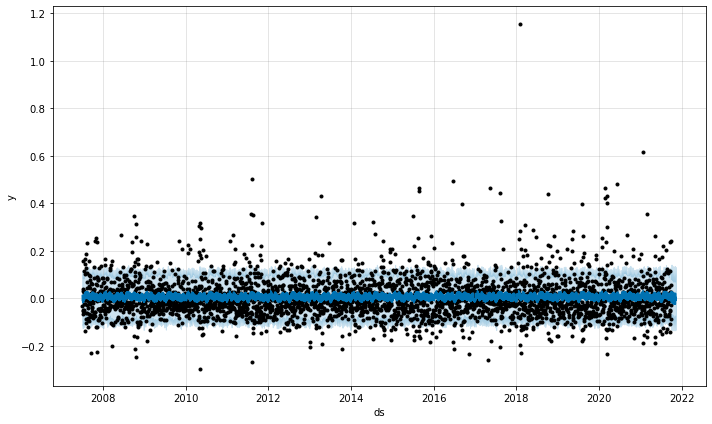

In [20]:
# Plot the Prophet predictions for the forecast_trends data
plot_forecast_trends = model.plot(forecast_trends)

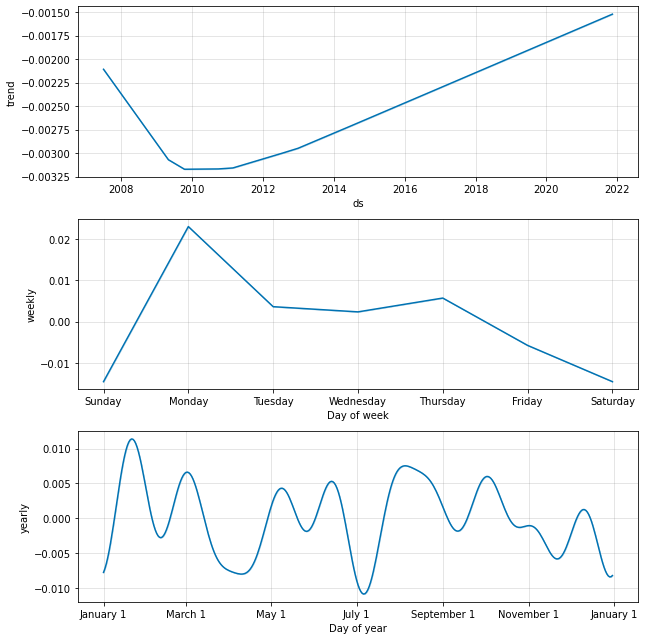

In [19]:
# Use the plot_components function to visualize the forecast results.
figures = model.plot_components(forecast_trends)

In [22]:
vix_cum_prod_df = (1+ticker_data_df[["^VIX"]]).cumprod()
vix_cum_prod_df

,^VIX
Date,
2007-07-02,NaN
2007-07-03,0.968831
2007-07-05,1.005195
2007-07-06,0.955844
2007-07-09,0.984416
...,...
2021-09-27,1.218182
2021-09-28,1.509740
2021-09-29,1.464935


In [23]:
vix_cum_prod_df = vix_cum_prod_df.reset_index()
vix_cum_prod_df.columns = ['ds', 'y']
vix_cum_prod_df

,ds,y
0,2007-07-02,NaN
1,2007-07-03,0.968831
2,2007-07-05,1.005195
3,2007-07-06,0.955844
4,2007-07-09,0.984416
...,...,...
3585,2021-09-27,1.218182
3586,2021-09-28,1.509740
3587,2021-09-29,1.464935
3588,2021-09-30,1.502597


In [24]:
vix_cum_prod_df = vix_cum_prod_df.sort_values(by=['ds'])

# Use hvPlot to visually inspect the price data
vix_cum_prod_df.hvplot(x='ds', y ='y')

:Curve   [ds]   (y)

In [26]:
model_cum_prod = Prophet()
model_cum_prod

In [27]:
# Fit the time-series model.
model_cum_prod.fit(vix_cum_prod_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 1000 hours (approx 40 days, or 1000/24 = 40)
future_trends_cum_prod = model_cum_prod.make_future_dataframe(periods=1000, freq='H')
future_trends_cum_prod

,ds
0,2007-07-02 00:00:00
1,2007-07-03 00:00:00
2,2007-07-05 00:00:00
3,2007-07-06 00:00:00
4,2007-07-09 00:00:00
...,...
4585,2021-11-11 12:00:00
4586,2021-11-11 13:00:00
4587,2021-11-11 14:00:00
4588,2021-11-11 15:00:00


In [29]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_trends_cum_prod = model_cum_prod.predict(future_trends_cum_prod)
forecast_trends_cum_prod

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-07-02 00:00:00,0.983185,0.346093,1.463109,0.983185,0.983185,-0.060668,-0.060668,-0.060668,0.018651,0.018651,0.018651,-0.079318,-0.079318,-0.079318,0.0,0.0,0.0,0.922517
1,2007-07-03 00:00:00,0.986457,0.347366,1.513324,0.986457,0.986457,-0.082206,-0.082206,-0.082206,0.003406,0.003406,0.003406,-0.085613,-0.085613,-0.085613,0.0,0.0,0.0,0.904251
2,2007-07-05 00:00:00,0.993001,0.348214,1.471992,0.993001,0.993001,-0.091391,-0.091391,-0.091391,0.007782,0.007782,0.007782,-0.099172,-0.099172,-0.099172,0.0,0.0,0.0,0.901610
3,2007-07-06 00:00:00,0.996272,0.317283,1.389427,0.996272,0.996272,-0.109218,-0.109218,-0.109218,-0.002945,-0.002945,-0.002945,-0.106273,-0.106273,-0.106273,0.0,0.0,0.0,0.887055
4,2007-07-09 00:00:00,1.006088,0.357569,1.473902,1.006088,1.006088,-0.109140,-0.109140,-0.109140,0.018651,0.018651,0.018651,-0.127791,-0.127791,-0.127791,0.0,0.0,0.0,0.896948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4585,2021-11-11 12:00:00,1.692954,1.249851,2.360861,1.692954,1.692954,0.125694,0.125694,0.125694,0.000860,0.000860,0.000860,0.124834,0.124834,0.124834,0.0,0.0,0.0,1.818648
4586,2021-11-11 13:00:00,1.692977,1.311037,2.396663,1.692977,1.692977,0.125135,0.125135,0.125135,0.000400,0.000400,0.000400,0.124736,0.124736,0.124736,0.0,0.0,0.0,1.818113
4587,2021-11-11 14:00:00,1.693000,1.236397,2.408873,1.693000,1.693000,0.124607,0.124607,0.124607,-0.000030,-0.000030,-0.000030,0.124637,0.124637,0.124637,0.0,0.0,0.0,1.817607
4588,2021-11-11 15:00:00,1.693023,1.286051,2.369971,1.693023,1.693023,0.124109,0.124109,0.124109,-0.000430,-0.000430,-0.000430,0.124539,0.124539,0.124539,0.0,0.0,0.0,1.817132


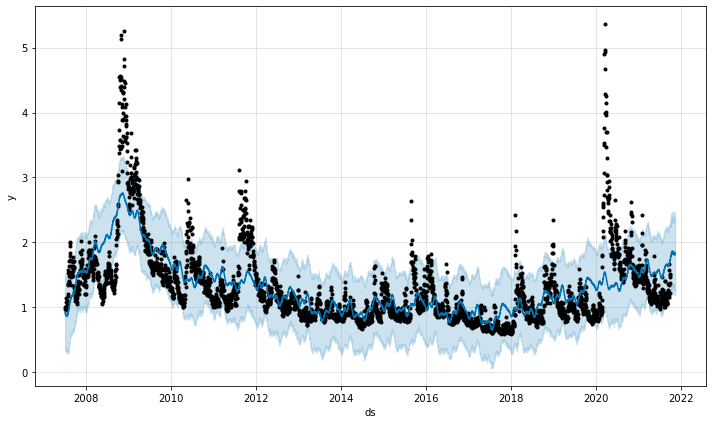

In [30]:
# Plot the Prophet predictions for the forecast_trends data
plot_forecast_trends_cum_prod = model_cum_prod.plot(forecast_trends_cum_prod)

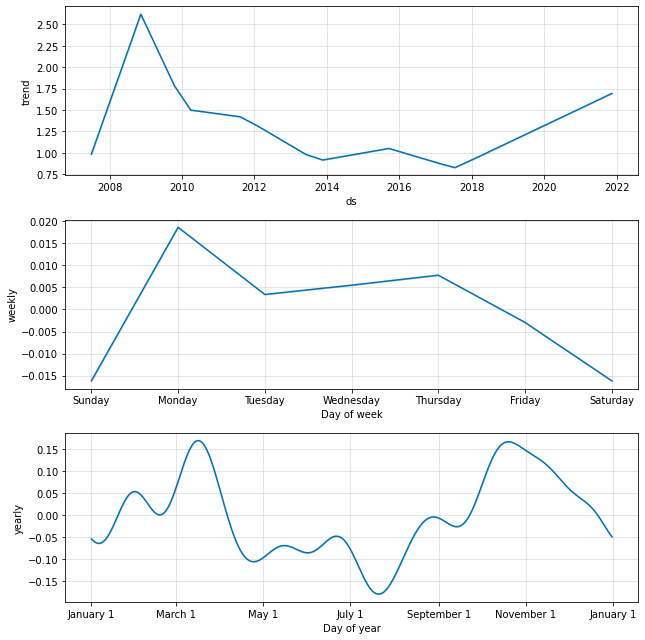

In [31]:
# Use the plot_components function to visualize the forecast results.
figures_cum_prod = model_cum_prod.plot_components(forecast_trends_cum_prod)